In [1]:
import healpy as hp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
hp.disable_warnings()

# Handle white noise with healpy 2 partial sky coverage
> Simulate white noise maps and use hitmaps
- categories: [cosmology, python, healpy]

In this second notebook, we will handle a case of partial sky coverage.

In [2]:
# Number based on Simons Observatory SAT UHF1 array of detectors

net = 10. * u.Unit("uK * sqrt(s)")

5 years with a efficiency of 20%:

In [3]:
integration_time_total = 5 * u.year * .2

## Download a hitmap

We can download a simulated hitmap for a Simons Observatory band, for now however, we assume a uniform coverage.

In [4]:
hitmap_url = "https://portal.nersc.gov/project/sobs/so_mapsims_data/v0.2/healpix/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz"

In [5]:
!wget $hitmap_url

--2020-12-11 10:32:00--  https://portal.nersc.gov/project/sobs/so_mapsims_data/v0.2/healpix/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.24, 128.55.206.26
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3212515 (3.1M) [application/x-gzip]
Saving to: ‘ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz.8’

ST0_UHF1_01_of_20.n 100%[===================>]   3.06M  3.12MB/s    in 1.0s    

2020-12-11 10:32:06 (3.12 MB/s) - ‘ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz.8’ saved [3212515/3212515]



In [6]:
hitmap = hp.read_map("ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz")

In [7]:
hitmap = hitmap > 0

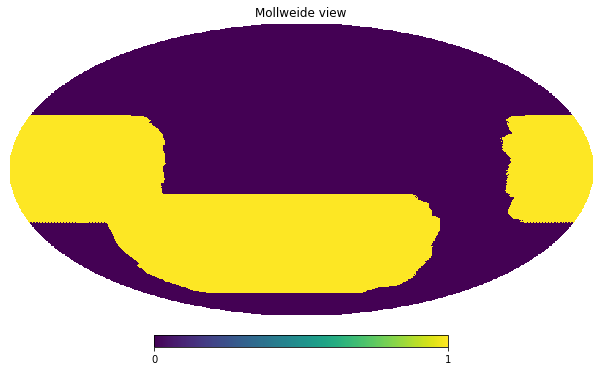

In [8]:
hp.mollview(hitmap)

## Uniform partial sky survey

As a reference, let's first start with the trivial case of uniform full sky coverage, i.e. we spend the same amount of observation time in each pixel.

In [9]:
nside = 512
npix = hp.nside2npix(nside)
npix_hit = hitmap.sum()

In [10]:
standard_deviation_per_pixel = (net / np.sqrt(integration_time_total/npix_hit)).decompose()

In [11]:
standard_deviation_per_pixel

<Quantity 1.9596849e-06 K>

In [12]:
m = np.nan * np.ones(npix, dtype=np.double) * standard_deviation_per_pixel.unit

In [13]:
m[hitmap] = np.random.normal(scale = standard_deviation_per_pixel.value, size=npix_hit) * standard_deviation_per_pixel.unit

In [14]:
m = m.to(u.uK)

In [15]:
m.value[np.isnan(m)] = hp.UNSEEN

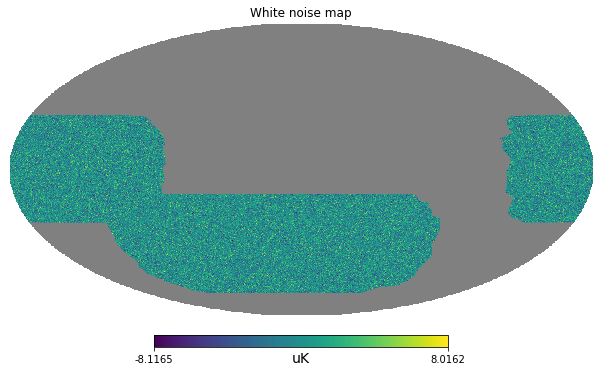

In [16]:
hp.mollview(m, unit=m.unit, title="White noise map")

## Power spectrum

In [17]:
sky_fraction = np.mean(hitmap)

In [18]:
cl = hp.anafast(m) / sky_fraction

In [19]:
cl[100:].mean()

1.5205726153293572e-05

In [20]:
m[hitmap].std()

<Quantity 1.95959376 uK>

In [21]:
pixel_area = hp.nside2pixarea(nside)

In [22]:
white_noise_cl = (standard_deviation_per_pixel**2 * pixel_area).to(u.uK**2)

In [23]:
white_noise_cl

<Quantity 1.53412656e-05 uK2>

In [24]:
white_noise_cl_full_sky = 3.9820426e-5 * u.uK**2

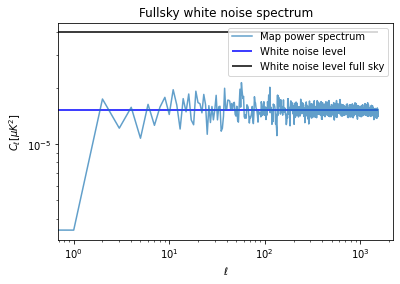

In [25]:
plt.figure(figsize=(6,4))
plt.loglog(cl, label="Map power spectrum", alpha=.7)
plt.hlines(white_noise_cl.value, 0, len(cl), color="blue",
           label="White noise level")
plt.hlines(white_noise_cl_full_sky.value, 0, len(cl),
           label="White noise level full sky")
plt.title("Fullsky white noise spectrum")
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell [\mu K ^ 2]$");

In [26]:
white_noise_cl / white_noise_cl_full_sky

<Quantity 0.38526121>

In [27]:
sky_fraction

0.38526121775309247